In [104]:
import numpy as np
# import scipy 
# from scipy.optimize import brentq    #equation solver
from scipy import optimize
# from scipy.stats import norm
# from scipy.optimize import minimize
import matplotlib.pyplot as plt
# import numpy.polynomial.chebyshev as chebyshev
import numba
from scipy import interpolate

# Solving the Aiyagari model with Python

## The consumer problem

$$
\max_{\left\{c_t, a_{t+1}\right\}_{t=0}^\infty} \mathbb{E}_t \left[\sum_{t=0}^{\infty} \beta^t \frac{c_t^{1- \sigma}}{1-\sigma}\right]
$$
subject to: 

$$
 c_t + a_{t+1}\leq (1+r) a_t + w l_t ,\ \forall t
$$

and the natural borrowing limit
$$
a_{t}\geq - b,\ \forall t
$$
Note that 
$$\min_{\mathbb{L}} l_{t} = 0 ,\ \forall t$$

so that the natural debt limit is 0 for all consumers. 

The Bellman equation for this problem is:

$$
V(l,a) = \max_{c,a'} \left[ \frac{c^{1- \sigma}}{1-\sigma} + \beta \sum_{l' \in \mathbb{L}}  V(l',a') \Pi(l' | l) \right]
$$ 
subject to:
$$
 c + a' = (1+r) a + w l
$$
$$
a'\geq - b
$$

Solving the representative firm problem we derive wages and the interest rate, net of depreciation:

$$
w_t = f_l(K_t,L_t) = (1 - \alpha) \left(\frac{K_t}{L_t}\right)^\alpha
$$

$$
r = f_k(K_t,L_t) - \delta = \alpha \left(\frac{L_t}{K_t}\right)^{1 - \alpha} - \delta
$$

## Stationary recursive equilibrium

In the Aiyagari model, a stationary recursive equilibrium is defined by prices $\{w, r\}$, aggregate quantities $K, Y, L$ , a value function $V(l,a)$, a policy function $a'(l,a)$ and a law of motion for the distribution of households $\lambda(l_t, a_t)$:
1. Agents solve their maximization problem as defined by the Bellman equation
2. Firms optimize their production, so that profits are zero in equilibrium
3. The law of motion is stationary
4. The resource constraint is satisfied:
    * $C + K = (1- \delta) K + F(K,L)$

## Demand for assets
Given the relationship between the interest rate and capital in equilibrium, demand for asset as a function of the interest rate $r$ is:
$$
K(r) = \left(\frac{\alpha}{r + \delta}\right)^{\frac{1}{1-\alpha}} L
$$

In [105]:
β  = 0.97
σ  = 0.6
α  = 0.3
δ  = 0.1
Π     = np.array([[.8, .2], [.5, .5]])
lstar = 0.5/0.7
kstar = ( (1/β - 1+δ) /(α*(lstar)**(1-α))) ** (1 / (α - 1))
print(kstar)

@numba.njit
def f(K, L):
    return K**α * L**(1 - α)

@numba.njit
def mpk(K):
    return α*(lstar/K)**(1-α) - δ

@numba.njit
def util(c):
        return (c**(1-σ))/(1-σ)
    
@numba.njit
def K_D(r):
    return (α/(r + δ))**(1/(1-α)) * lstar

@numba.njit
def wage(K):
    return (1 - α) * (K/lstar) ** α


2.334990964546343


In [3]:
rstar = mpk(kstar)
print(rstar)

0.030927835051546504


In [3]:
rgrid = np.linspace(-δ+1E-2, β**-1 -1, 100)
kgrid = np.array([K_D(xi) for xi in rgrid])


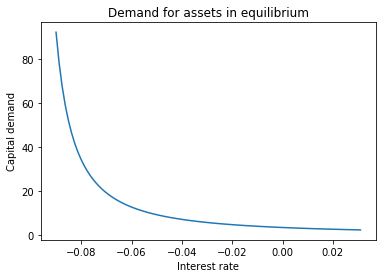

In [166]:
plt.plot(rgrid, kgrid)
plt.xlabel("Interest rate")
plt.ylabel('Capital demand')
plt.title('Demand for assets in equilibrium');

Demand for capital by firms is decreasing with the level of the interest rate. 

## Equilibrium wage

In [167]:
wgrid = np.array([wage(xi) for xi in kgrid])


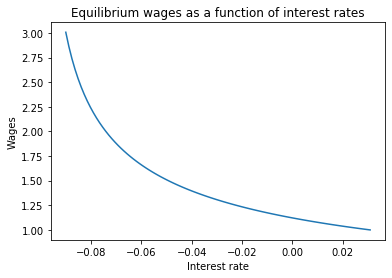

In [168]:
plt.plot(rgrid, wgrid)
plt.xlabel("Interest rate")
plt.ylabel('Wages')
plt.title('Equilibrium wages as a function of interest rates');

## Solving the household's problem


### Value function algorithm

In [106]:

# Compute value function today, from guess Value function tomorrow
@numba.njit
def Vendog(aplus, a, r, w, Vh, Vl, π):

        c = (1+r)*a + w - aplus
        if c < 0:
            result = -5000000
    
        else:
            today = util(c)
    #         print(today)
            tomorrow = β * (π[0] * Vh + π[1] * Vl)
    #         print(Vtomorrow)
            bellman = today  + tomorrow # avoid negative consumption
            result = bellman
        
        return  result
    

# Backward iteration
@numba.njit
def backward_iterate(maxindex, V, a, r, w, Π, N):
    maxindex = np.empty_like(V)
    Vupdate  = np.empty_like(V)
    Vl = V[:N]
    Vh = V[N:]
    grid = a[:N]
    maxindexl = np.empty_like(grid)
    maxindexh = np.empty_like(grid)
    
    for ia, a_cur in enumerate(grid):
        
        valuel = np.empty_like(grid)
        valueh = np.empty_like(grid)
        
        for ia2, a_cur2 in enumerate(grid):
            #compute value function for all availabe saving choices
            valuel[ia2] = Vendog(a_cur2, a_cur, r, 0, Vh[ia2], Vl[ia2], Π[1,:])
            valueh[ia2] = Vendog(a_cur2, a_cur, r, w, Vh[ia2], Vl[ia2], Π[0,:])
#         print("Low value", valuel)
#         print("high value", valueh)
        # find optimal saving decision
        indexl         = np.argmax(valuel)
        indexh         = np.argmax(valueh)
        maxindexl[ia]  = indexl
        maxindexh[ia]  = indexh
#         print(maxindex)
        # compute new value function
        Vl[ia]     = valuel[indexl]
        Vh[ia]     = valueh[indexh]
        #             print(V[ia])
    
    Vupdate[:N]   = Vl
    Vupdate[N:]   = Vh
    policy        = np.stack((maxindexl, maxindexh))
    maxindexh = maxindexh + N                                            # Shift the indexing
    maxindex[:N]  = maxindexl
    maxindex[N:]  = maxindexh

    return maxindex, Vupdate, policy

In [107]:
# Iteration algorithm

@numba.njit
def ss_policy(r, w, a, Π, N):
    maxindex = np.zeros_like(a)
    V    = 0.3*a
    Vold    = np.zeros_like(a)
    
    for it in range(1000):
#         print("Old V", Vold)
        maxindex, V, policy = backward_iterate(maxindex, V, a, r, w, Π, N)
#         print("New V", V)
#         print(np.linalg.norm(V - Vold))
        if it % 10 == 1 and  np.linalg.norm(V - Vold) < 1E-10:

            print("convergence in", it, " iterations!")
            return maxindex.astype(np.int32), V, policy.astype(np.int32)
        

        Vold = np.copy(V) # avoid updating both Vold and V by making a copy
        

In [108]:
N = 300
alow = 0.01
aup  = 10
a = np.linspace(alow, aup, N)
a = np.tile(a, 2)


r0 = mpk(kstar)
K0 = K_D(r0)
w0 = wage(kstar)

%time maxindex, V_notax, policy = ss_policy(r0, w0, a, Π, N)


convergence in 561  iterations!
CPU times: user 3.23 s, sys: 4 ms, total: 3.23 s
Wall time: 3.24 s


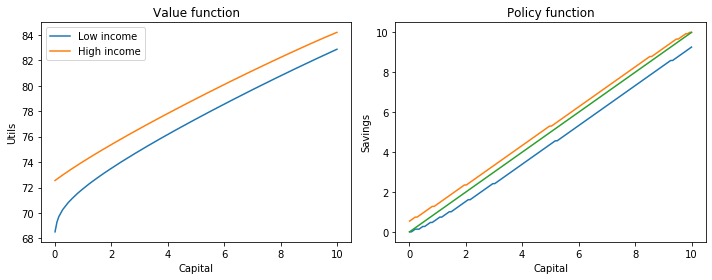

In [6]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Value function')
ax2.set_title('Policy function')
ax1.plot(a[:N], V_notax[:N], label="Low income")
ax1.plot(a[:N], V_notax[N:], label ="High income")
ax2.plot(a[:N], a[maxindex[:N]])
ax2.plot(a[N:], a[maxindex[N:]])
ax2.plot(a[N:], a[N:])
ax1.legend()
ax1.set(xlabel="Capital", ylabel="Utils")
ax2.set(xlabel="Capital", ylabel="Savings")
plt.tight_layout()

### Simulate the economy to get steady state capital level A

In [109]:
@numba.njit
def update(zi, index, policy):
    # first get updated policy for capital
    indexplus = policy[zi, index]
    
    # then do random draw for the state
    zi_plus = np.random.binomial(1, Π[(1-zi),0])
#     print(Π[(1-zi),0])
    return zi_plus, indexplus


@numba.njit
def montecarlo_means(a, policy, indexstart, zistart, T, T_drop):
    
    
    index   =  indexstart
    zi = zistart
    
    np.random.seed(0)
        
    for i in range(T_drop):
        # burn-in to account for non-randomness of initial condition, don't use these
        zi, index = update(zi, index, policy)
      
    asum = 0

    for _ in range(T - T_drop):
        asum += a[index]
        zi, index = update(zi, index, policy)
        
    # return averages
    return asum/(T-T_drop)


In [110]:
indexstart = np.argmin(np.abs(a[:N] - kstar))
A = montecarlo_means(a, policy, indexstart, 0, 1_000_000, 10_000)
print(A)

6.519128320766625


#### Plot aggregate savings supply as a function of r

In [111]:
alow=0.1
aup=8
N=300
a = np.linspace(alow, aup, N)
a = np.tile(a, 2)

#Get capital supply for one value of r
@numba.njit
def price_to_capital(r, Π):
    w = wage(K_D(r))
#     print("Wage", w)
    maxindex, V, policy = ss_policy(r, w, a, Π, N)
    
    indexstart = np.argmin(np.abs(a[:N] - kstar))
    A   = montecarlo_means(a, policy, indexstart, 0, 1_000_000, 10_000)
        
    return A


In [79]:

# @numba.jit
def capital_supply(rgrid):
    
    agrid = np.empty_like(rgrid)
    
    for ir, r_cur in enumerate(rgrid):
        agrid[ir] = price_to_capital(rgrid[ir], Π)
    
    return agrid


    

In [12]:
rgrid = np.linspace(-δ+1E-1, β**-1 -1, 20)
agrid = capital_supply(rgrid)

convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 561  iterations!


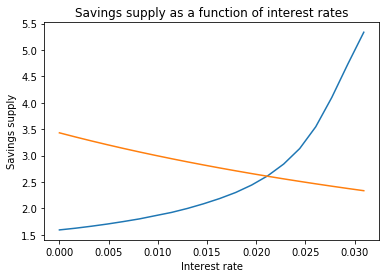

In [13]:
kgrid = np.array([K_D(xi) for xi in rgrid])

plt.plot(rgrid, agrid)
plt.plot(rgrid, kgrid)
plt.xlabel("Interest rate")
plt.ylabel('Savings supply')
plt.title('Savings supply as a function of interest rates');

Aggregate saving supply is increasing with the interest rate. And it should intersect with the aggregate demand equation at the steady state level of interest rate. 

### Finding the stationary equilibrium

In [112]:
#compute excess supply
@numba.njit
def excess_supply(r, Π):
    A = price_to_capital(r, Π)
    K = K_D(r)
    error = A - K
#     print("Excess supply", error)
    return error
    

# Find stationary equilibrium r by bisection
@numba.njit
def stationary_equilibrium(rgrid, iter=20):
    r0 = np.mean(rgrid)
    K0 = K_D(r0)
    w0 = wage(kstar)
    r_u = max(rgrid)
    r_l = min(rgrid)
#     print("interval: [", r_l, ",", r_u,"]")
    r_m = (r_u + r_l)/2
    f_m = excess_supply(r_m, Π)
    f_l = excess_supply(r_l, Π)
    f_u = excess_supply(r_u, Π)
    iteration_counter = 0
    
    if f_u*f_l > 0:
        print("Bisection method fails.")
        return None

    while np.abs(r_l - r_u) > 10E-8 and iteration_counter < iter :

        if f_l*f_m > 0:   # i.e. same sign
            r_l = r_m
            f_l = f_m
        else:
            r_u = r_m
        r_m = (r_u + r_l)/2
        f_m = excess_supply(r_m, Π)
        iteration_counter += 1
#         print("interval: [", r_l, ",", r_u,"]")
    print("interval: [", r_l, ",", r_u,"]")
    print("convergence of bisection ", iteration_counter, "iterations!")
    return r_m



In [113]:
rgrid = np.linspace(-δ+1.2E-1, 0.05, 100)
rstar = stationary_equilibrium(rgrid)

convergence in 551  iterations!
convergence in 571  iterations!
convergence in 541  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
interval: [ 0.02110126495361327 , 0.021101322174072255 ]
convergence of bisection  19 iterations!


In [17]:
print(rstar)

0.021101293563842764


The interest rate in the stationary equilibrium is lower than the interest rate in the deterministic equilibrium. This is because risks generate precautionary savings, increasing the price of savings in equilibrium.

In [114]:
Kstar = K_D(rstar)
w = wage(Kstar)
maxindex, V, policy = ss_policy(rstar, w, a, Π, N)
Vl_notax = V_notax[:N]
Vh_notax = V_notax[N:]
Ul = Vl_notax[np.argmin(np.abs(a[:N] - Kstar))]
Uh = Vh_notax[np.argmin(np.abs(a[:N] - Kstar))]
print(Ul)

convergence in 571  iterations!
75.13832232564941


## Aiyagari model with taxes on capital income

$$
\max_{\left\{c_t, a_{t+1}\right\}_{t=0}^\infty} \mathbb{E}_t \left[\sum_{t=0}^{\infty} \beta^t \frac{c_t^{1- \sigma}}{1-\sigma}\right]
$$
subject to: 

$$
     c_t + a_{t+1}\leq (1+ r) a_t + w l_t + T,\ \forall t
$$

and the natural borrowing limit
$$
a_{t}\geq - b,\ \forall t
$$
Note that 
$$\min_{\mathbb{L}} income_{t} = T ,\ \forall t$$

so that the natural asset limit is $$ - \frac{T}{r} $$ for all consumers. 

The Bellman equation for this problem is:

$$
V(l,a) = \max_{c,a'} \left[ \frac{c^{1- \sigma}}{1-\sigma} + \beta \sum_{l' \in \mathbb{L}}  V(l',a') \Pi(l' | l) \right]
$$ 
subject to:
$$
 c + a' = (1+ r) a + w l + T
$$
$$
a'\geq - \frac{T}{r}
$$

Solving the representative firm problem the interest rate is now a function of taxes:

$$
r = \frac{f_k(K_t,L_t) - \delta}{1 + \tau}= \frac{ \alpha  \left(\frac{L_t}{K_t}\right)^{1 - \alpha} - \delta}{1 + \tau}
$$

## Demand for assets
Given the relationship between the interest rate and capital in equilibrium, demand for asset as a function of the interest rate $r$ and $\tau$ is:
$$
K(r) = \left(\frac{\alpha}{(1 + \tau)(r + \delta)}\right)^{\frac{1}{1-\alpha}} L
$$

## Computing equilibrium with the new setting

In [115]:
τ  = 0.1

@numba.njit
def K_D(r):
    return (α/((1 + τ)*(r + δ)))**(1/(1-α)) * lstar

@numba.njit
def mpk(K):
    return (α*(lstar/K)**(1-α) - δ) / (1 + τ)

In [116]:

# Compute value function today, from guess Value function tomorrow
@numba.njit
def Vendog(aplus, a, r, w, tax, Vh, Vl, π):

        c = (1+r)*a + w - aplus + tax
        if c < 0:
            result = -5000000
    
        else:
            today = util(c)
    #         print(today)
            tomorrow = β * (π[0] * Vh + π[1] * Vl)
    #         print(Vtomorrow)
            bellman = today  + tomorrow # avoid negative consumption
            result = bellman
        
        return  result
    

# Backward iteration
@numba.njit
def backward_iterate(maxindex, V, a, r, w, Π, N):
    tax = K_D(r)*τ*(1+r)
    maxindex = np.empty_like(V)
    Vupdate  = np.empty_like(V)
    Vl = V[:N]
    Vh = V[N:]
    grid = a[:N]
    maxindexl = np.empty_like(grid)
    maxindexh = np.empty_like(grid)
    
    for ia, a_cur in enumerate(grid):
        
        valuel = np.empty_like(grid)
        valueh = np.empty_like(grid)
        
        for ia2, a_cur2 in enumerate(grid):
            #compute value function for all availabe saving choices
            valuel[ia2] = Vendog(a_cur2, a_cur, r, 0, tax, Vh[ia2], Vl[ia2], Π[1,:])
            valueh[ia2] = Vendog(a_cur2, a_cur, r, w, tax, Vh[ia2], Vl[ia2], Π[0,:])

        # find optimal saving decision
        indexl         = np.argmax(valuel)
        indexh         = np.argmax(valueh)
        maxindexl[ia]  = indexl
        maxindexh[ia]  = indexh

        # compute new value function
        Vl[ia]     = valuel[indexl]
        Vh[ia]     = valueh[indexh]
        #             print(V[ia])
    
    Vupdate[:N]   = Vl
    Vupdate[N:]   = Vh
    policy        = np.stack((maxindexl, maxindexh))
    maxindexh = maxindexh + N                                            # Shift the indexing
    maxindex[:N]  = maxindexl
    maxindex[N:]  = maxindexh

    return maxindex, Vupdate, policy

In [117]:
# Iteration algorithm

@numba.njit
def ss_policy(r, w, a, Π, N):
    maxindex = np.zeros_like(a)
    V    = 0.3*a
    Vold    = np.zeros_like(a)
    
    for it in range(1000):
#         print("Old V", Vold)
        maxindex, V, policy = backward_iterate(maxindex, V, a, r, w, Π, N)
#         print("New V", V)
#         print(np.linalg.norm(V - Vold))
        if it % 10 == 1 and  np.linalg.norm(V - Vold) < 1E-10:

            print("convergence in", it, " iterations!")
            return maxindex.astype(np.int32), V, policy.astype(np.int32)
        

        Vold = np.copy(V) # avoid updating both Vold and V by making a copy
        

In [118]:
r0 = mpk(kstar)
K0 = K_D(r0)
w0 = wage(kstar)

N = 300
alow = - K0*τ*(1+r0)/r0
print(alow)
aup  = 10
a = np.linspace(alow, aup, N)
a = np.tile(a, 2)

%time maxindex, V, policy = ss_policy(r0, w0, a, Π, N)


-7.686109836362195
convergence in 581  iterations!
CPU times: user 3.3 s, sys: 8 ms, total: 3.31 s
Wall time: 3.32 s


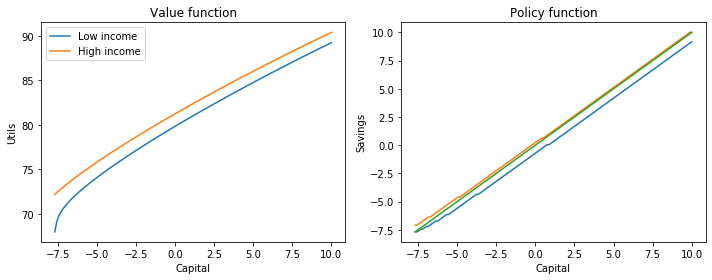

In [36]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.set_title('Value function')
ax2.set_title('Policy function')
ax1.plot(a[:N], V[:N], label="Low income")
ax1.plot(a[:N], V[N:], label ="High income")
ax2.plot(a[:N], a[maxindex[:N]])
ax2.plot(a[N:], a[maxindex[N:]])
ax2.plot(a[N:], a[N:])
ax1.legend()
ax1.set(xlabel="Capital", ylabel="Utils")
ax2.set(xlabel="Capital", ylabel="Savings")
plt.tight_layout()

In [119]:
indexstart = np.argmin(np.abs(a[:N] - kstar))
A = montecarlo_means(a, policy, indexstart, 0, 1_000_000, 10_000)
print(A)

-3.184734021700767


In [120]:
@numba.njit
def update(zi, index, policy):
    # first get updated policy for capital
    indexplus = policy[zi, index]
    
    # then do random draw for the state
    zi_plus = np.random.binomial(1, Π[(1-zi),0])
#     print(Π[(1-zi),0])
    return zi_plus, indexplus


@numba.njit
def montecarlo_means(a, policy, indexstart, zistart, T, T_drop):
    
    
    index   =  indexstart
    zi = zistart
    
    np.random.seed(0)
        
    for i in range(T_drop):
        # burn-in to account for non-randomness of initial condition, don't use these
        zi, index = update(zi, index, policy)
      
    asum = 0

    for _ in range(T - T_drop):
        asum += a[index]
        zi, index = update(zi, index, policy)
        
    # return averages
    return asum/(T-T_drop)


In [121]:
N=300
a = np.linspace(alow, aup, N)
a = np.tile(a, 2)

#Get capital supply for one value of r
@numba.njit
def price_to_capital(r, Π):
    w = wage(K_D(r))
#     print("Wage", w)
    maxindex, V, policy = ss_policy(r, w, a, Π, N)
    
    indexstart = np.argmin(np.abs(a[:N] - kstar))
    A   = montecarlo_means(a, policy, indexstart, 0, 1_000_000, 10_000)
        
    return A

In [122]:

# @numba.jit
def capital_supply(rgrid):
    
    agrid = np.empty_like(rgrid)
    
    for ir, r_cur in enumerate(rgrid):
        agrid[ir] = price_to_capital(rgrid[ir], Π)
    
    return agrid



In [41]:
N=300
rgrid = np.linspace(-δ+1E-1, β**-1 -1, 20)
agrid = capital_supply(rgrid)

convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 581  iterations!
convergence in 581  iterations!
convergence in 581  iterations!
convergence in 581  iterations!
convergence in 581  iterations!
convergence in 561  iterations!


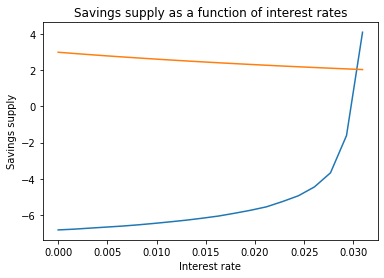

In [42]:
kgrid = np.array([K_D(xi) for xi in rgrid])

plt.plot(rgrid, agrid)
plt.plot(rgrid, kgrid)
plt.xlabel("Interest rate")
plt.ylabel('Savings supply')
plt.title('Savings supply as a function of interest rates');

In [123]:
#compute excess supply
@numba.njit
def excess_supply(r, Π):
    A = price_to_capital(r, Π)
    K = K_D(r)
    error = A - K
#     print("Excess supply", error)
    return error
    

# Find stationary equilibrium r by bisection
@numba.njit
def stationary_equilibrium(rgrid, iter=20):
    r0 = np.mean(rgrid)
    K0 = K_D(r0)
    w0 = wage(kstar)
    r_u = max(rgrid)
    r_l = min(rgrid)
#     print("interval: [", r_l, ",", r_u,"]")
    r_m = (r_u + r_l)/2
    f_m = excess_supply(r_m, Π)
    f_l = excess_supply(r_l, Π)
    f_u = excess_supply(r_u, Π)
    iteration_counter = 0
    
    if f_u*f_l > 0:
        print("Bisection method fails.")
        return None

    while np.abs(r_l - r_u) > 10E-8 and iteration_counter < iter :

        if f_l*f_m > 0:   # i.e. same sign
            r_l = r_m
            f_l = f_m
        else:
            r_u = r_m
        r_m = (r_u + r_l)/2
        f_m = excess_supply(r_m, Π)
        iteration_counter += 1
        
    print("interval: [", r_l, ",", r_u,"]")
    print("convergence of bisection ", iteration_counter, "iterations!")
    return r_m



In [124]:
rgrid = np.linspace(-δ+1.2E-1, β**-1 -1, 100)
rstar_tax = stationary_equilibrium(rgrid)

convergence in 581  iterations!
convergence in 571  iterations!
convergence in 561  iterations!
convergence in 581  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 561  iterations!
convergence in 571  iterations!
convergence in 571  iterations!
interval: [ 0.030568998671069696 , 0.030569082043834676 ]
convergence of bisection  17 iterations!


In [125]:
print("Interest rate in equilibrium with no taxes", rstar, "\n",
      "Interest rate in equilibrium with taxes", rstar_tax)

Interest rate in equilibrium with no taxes 0.021101293563842764 
 Interest rate in equilibrium with taxes 0.030569040357452185


The interest rate in the stationary equilibrium is lower than the interest rate in the deterministic equilibrium. This is because risks generate precautionary savings, increasing the price of savings in equilibrium.

In [126]:
Kstar_tax = K_D(rstar_tax)
w = wage(Kstar_tax)
maxindex, V, policy = ss_policy(rstar_tax, w, a, Π, N)

Vl_tax = V[:N]
print(Vl_tax.shape)
Vh_tax = V[N:]
print(Vh_tax.shape)
Ul_tax = Vl_tax[np.argmin(np.abs(a[:N] - Kstar_tax))]
Uh_tax = Vh_tax[np.argmin(np.abs(a[:N] - Kstar_tax))]

convergence in 571  iterations!
(300,)
(300,)


In [129]:
print("Value in equilibrium with taxes", Ul_tax, Uh_tax, "\n",
      "Value in equilibrium with no taxes", Ul, Uh)

Value in equilibrium with taxes 80.85108460712318 82.2482988803689 
 Value in equilibrium with no taxes 75.13832232564941 76.85597073343098
